In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files

In [3]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
base_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data'

In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [7]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 13 lớp (sinh viên): ['Anh', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong train: 556
Phân bố số lượng ảnh theo lớp: {'Anh': 48, 'banAnh': 57, 'Binh': 50, 'Duc': 39, 'Hoang': 43, 'Hung': 29, 'KAnh': 55, 'Lan': 19, 'Long': 52, 'NAnh': 32, 'Nhung': 44, 'Son': 46, 'TAnh': 42}

Thư mục validation có 13 lớp (sinh viên): ['Anh', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong validation: 169
Phân bố số lượng ảnh theo lớp: {'Anh': 13, 'banAnh': 17, 'Binh': 15, 'Duc': 12, 'Hoang': 14, 'Hung': 10, 'KAnh': 16, 'Lan': 6, 'Long': 15, 'NAnh': 10, 'Nhung': 14, 'Son': 14, 'TAnh': 13}

Thư mục test có 13 lớp (sinh viên): ['Anh', 'banAnh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh']
Tổng số ảnh trong test: 99
Phân bố số lượng ảnh theo lớp: {'Anh': 9, 'banAnh': 10, 'Binh': 9, 'Duc': 6, 'Hoang': 9, 'Hung': 5, 'KA

In [8]:
# Cấu hình tham số
IMG_SIZE = 224  # Kích thước đầu vào cho MobileNetV2
BATCH_SIZE = 32
EPOCHS = 30

In [9]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 13
Các lớp: ['Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [10]:
# Data augmentation cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 556 images belonging to 13 classes.
Found 169 images belonging to 13 classes.
Found 99 images belonging to 13 classes.


In [12]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
images, labels = next(train_generator)

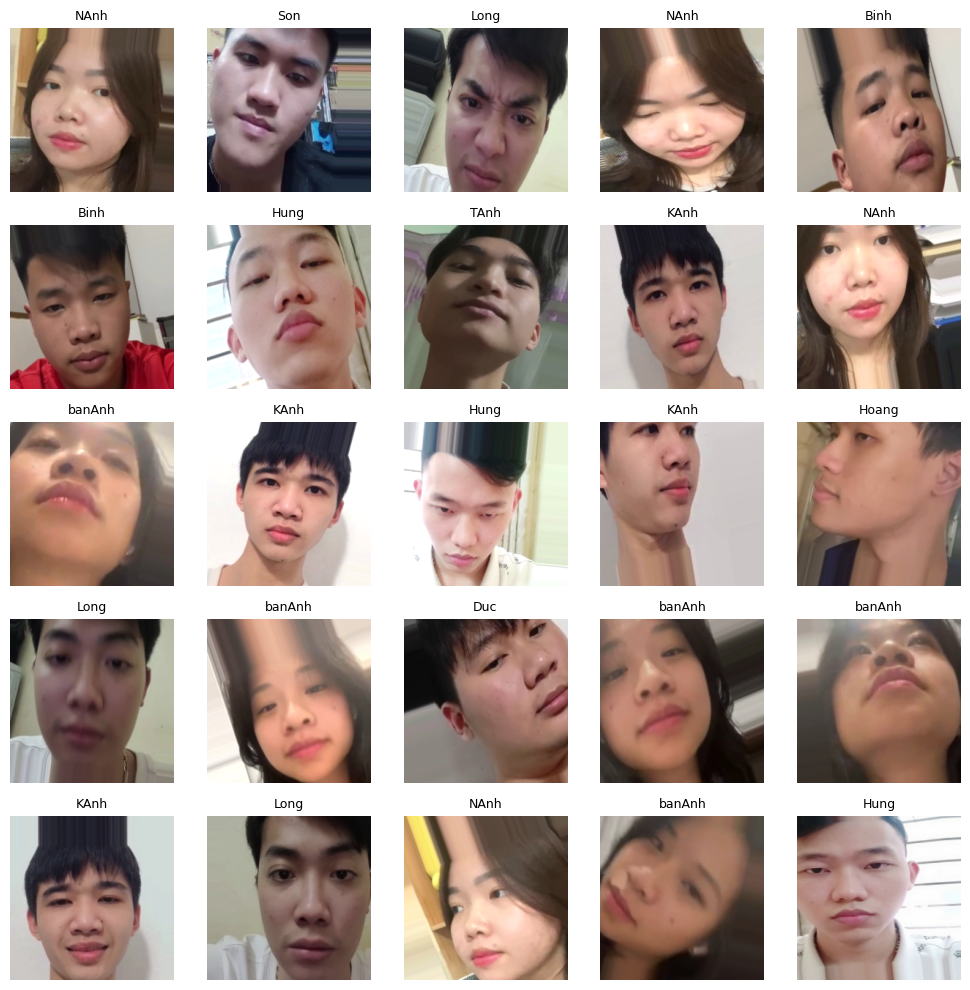

In [14]:
show_batch(images, labels, train_generator.class_indices)

In [15]:
def build_model(num_classes):
    # Tải MobileNetV2 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp của mô hình cơ sở
    for layer in base_model.layers:
        layer.trainable = False

    # Thêm các lớp mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Lớp output cho nhận diện khuôn mặt (số lượng lớp = số sinh viên)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Biên dịch model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [16]:
model, base_model = build_model(num_classes)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,101,197 (15.64 MB)

 Trainable params: 1,843,213 (7.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [18]:
# Thư mục để lưu mô hình
model_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models'
os.makedirs(model_dir, exist_ok=True)

In [19]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [20]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [21]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [22]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.2136 - loss: 2.5777 
Epoch 1: val_accuracy improved from -inf to 0.72500, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 395s 23s/step - accuracy: 0.2207 - loss: 2.5531 - val_accuracy: 0.7250 - val_loss: 0.9757 - learning_rate: 0.0010
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4062 - loss: 1.8200

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.72500 to 0.76250, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.4062 - loss: 1.8200 - val_accuracy: 0.7625 - val_loss: 0.8750 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.6302 - loss: 1.1303
Epoch 3: val_accuracy improved from 0.76250 to 0.81875, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 856ms/step - accuracy: 0.6319 - loss: 1.1242 - val_accuracy: 0.8188 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 4/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7500 - loss: 0.6509
Epoch 4: val_accuracy improved from 0.81875 to 0.86875, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.7500 - loss: 0.6509 - val_accuracy: 0.8687 - val_loss: 0.4283 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7886 - loss: 0.6432
Epoch 5: val_accuracy improved from 0.86875 to 0.92500, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - accuracy: 0.7883 - loss: 0.6430 - val_accuracy: 0.9250 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 6/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8125 - loss: 0.5713
Epoch 6: val_accuracy did not improve from 0.92500
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.8125 - loss: 0.5713 - val_accuracy: 0.9062 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8518 - loss: 0.4726
Epoch 7: val_accuracy did not improve from 0.92500
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 793ms/step - accuracy: 0.8526 - loss: 0.4712 - val_accuracy: 0.9000 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 8/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8750 - loss: 0.4119
Epoch 8: val_accuracy did not improve from 0.92500
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.8750 - loss: 0.4119 - val_accuracy: 0.9125 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 9/30
17/17 ━━━━━━━━

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.8438 - loss: 0.4035 - val_accuracy: 0.9375 - val_loss: 0.1530 - learning_rate: 0.0010
Epoch 11/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.8697 - loss: 0.2806
Epoch 11: val_accuracy improved from 0.93750 to 0.97500, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 870ms/step - accuracy: 0.8705 - loss: 0.2803 - val_accuracy: 0.9750 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 12/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9375 - loss: 0.2319
Epoch 12: val_accuracy did not improve from 0.97500
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.9375 - loss: 0.2319 - val_accuracy: 0.9625 - val_loss: 0.1161 - learning_rate: 0.0010
Epoch 13/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9106 - loss: 0.2787
Epoch 13: val_accuracy did not improve from 0.97500
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9108 - loss: 0.2776 - val_accuracy: 0.9438 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 14/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8750 - loss: 0.4649
Epoch 14: val_accuracy did not improve from 0.97500

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.8750 - loss: 0.4649 - val_acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 845ms/step - accuracy: 0.9435 - loss: 0.1896 - val_accuracy: 0.9812 - val_loss: 0.0529 - learning_rate: 2.0000e-04
Epoch 16/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9688 - loss: 0.0792
Epoch 16: val_accuracy did not improve from 0.98125
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9688 - loss: 0.0792 - val_accuracy: 0.9812 - val_loss: 0.0536 - learning_rate: 2.0000e-04
Epoch 17/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9586 - loss: 0.1303
Epoch 17: val_accuracy improved from 0.98125 to 0.99375, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9585 - loss: 0.1310 - val_accuracy: 0.9937 - val_loss: 0.0545 - learning_rate: 2.0000e-04
Epoch 18/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9688 - loss: 0.1616
Epoch 18: val_accuracy did not improve from 0.99375
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9688 - loss: 0.1616 - val_accuracy: 0.9937 - val_loss: 0.0505 - learning_rate: 2.0000e-04
Epoch 19/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9526 - loss: 0.1321
Epoch 19: val_accuracy did not improve from 0.99375
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9528 - loss: 0.1317 - val_accuracy: 0.9875 - val_loss: 0.0441 - learning_rate: 2.0000e-04
Epoch 20/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9688 - loss: 0.1228
Epoch 20: val_accuracy did not improve from 0.99375
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.9688 - loss: 0.1228 - val_accuracy: 0.9875 - val_loss: 0.0445 - learning_rate: 2.0000e-04
Epoch 21/

## Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [23]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-30]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Mở khóa 30 lớp cuối
    layer.trainable = True

In [24]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [26]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    verbose=1
)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.6693 - loss: 1.1536
Epoch 1: val_accuracy improved from -inf to 0.98125, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250406-165901/best_model_stage2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6710 - loss: 1.1462 - val_accuracy: 0.9812 - val_loss: 0.0601 - learning_rate: 1.0000e-05
Epoch 2/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5938 - loss: 1.4171
Epoch 2: val_accuracy did not improve from 0.98125
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - accuracy: 0.5938 - loss: 1.4171 - val_accuracy: 0.9812 - val_loss: 0.0604 - learning_rate: 1.0000e-05
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7520 - loss: 0.7576
Epoch 3: val_accuracy did not improve from 0.98125
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 793ms/step - accuracy: 0.7533 - loss: 0.7546 - val_accuracy: 0.9812 - val_loss: 0.0648 - learning_rate: 1.0000e-05
Epoch 4/10
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9062 - loss: 0.5357
Epoch 4: val_accuracy did not improve from 0.98125

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9062 - loss: 0.5357 - va

## 8. Đánh giá mô hình trên tập test

In [27]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [28]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 1.0000 - loss: 0.0201
Test accuracy: 1.0000
Test loss: 0.0171


In [29]:
# Dự đoán trên tập test
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
test_labels = test_generator.classes[:len(y_pred_classes)]

# In báo cáo phân loại
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Classification Report:

              precision    recall  f1-score   support

         Anh       1.00      1.00      1.00         9
        Binh       1.00      1.00      1.00         9
         Duc       1.00      1.00      1.00         6
       Hoang       1.00      1.00      1.00         9
        Hung       1.00      1.00      1.00         5
        KAnh       1.00      1.00      1.00        11
         Lan       1.00      1.00      1.00         3
        Long       1.00      1.00      1.00        10
        NAnh       1.00      1.00      1.00         5
       Nhung       1.00      1.00      1.00         7
         Son       1.00      1.00      1.00         7
        TAnh       1.00      1.00      1.00         8
      banAnh       1.00      1.00      1.00        10

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



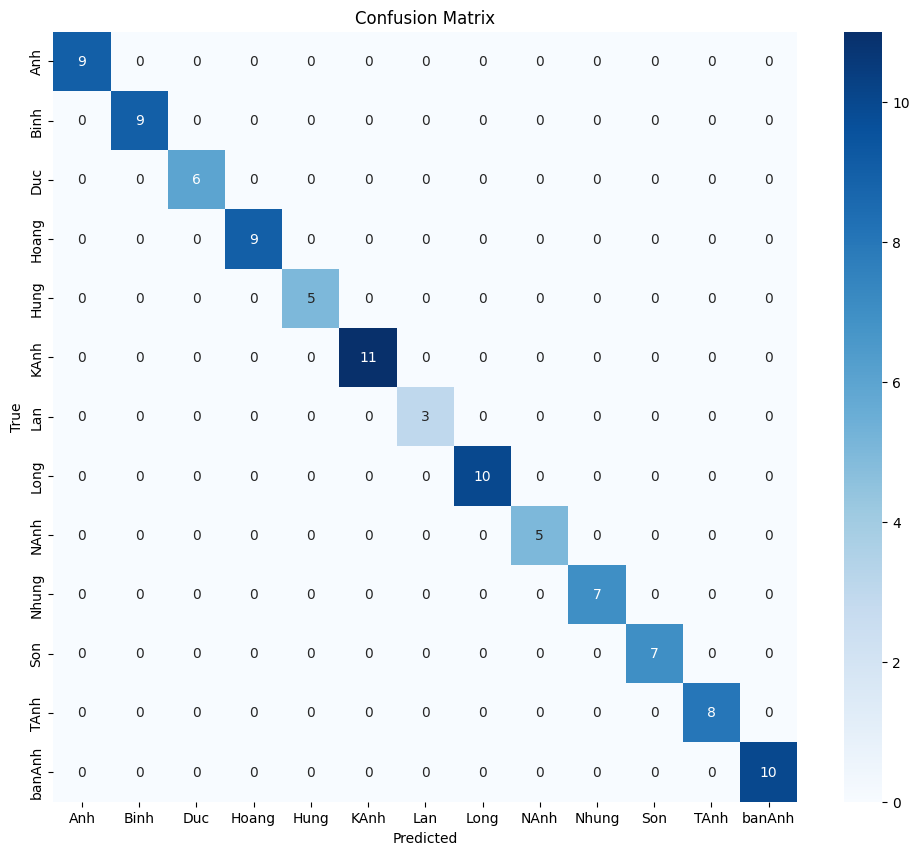

In [30]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hiển thị các kết quả dự đoán

In [31]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [32]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

Output hidden; open in https://colab.research.google.com to view.

In [33]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

Hiển thị các dự đoán sai trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Không có dự đoán sai nào được tìm thấy trong tập test!


## Vẽ đồ thị quá trình huấn luyện

In [34]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

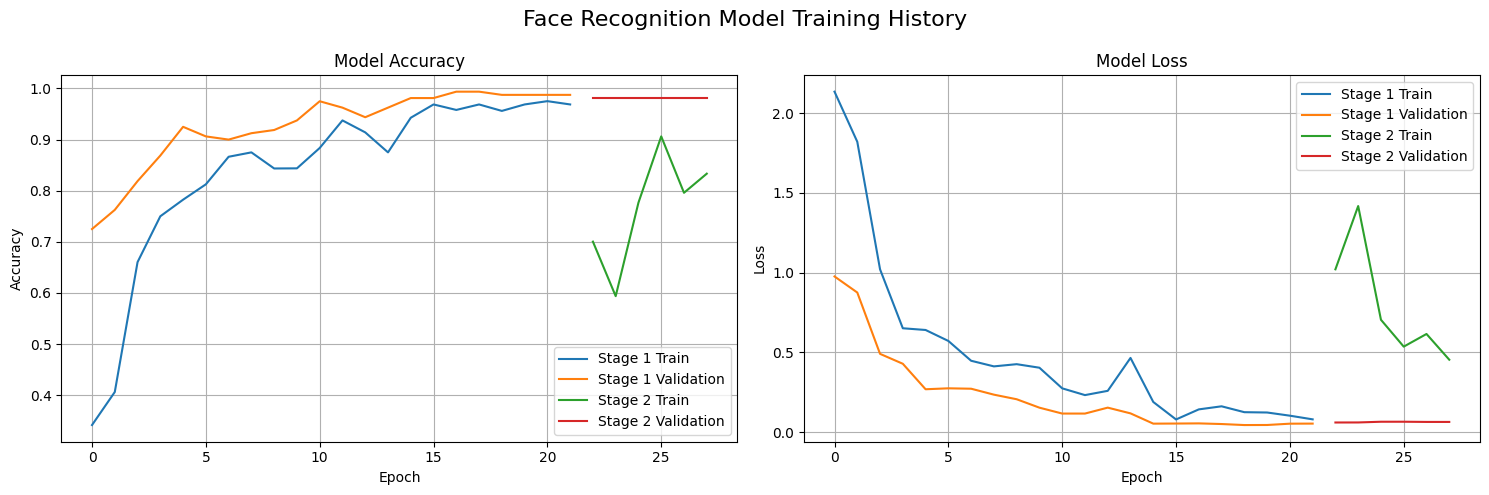

In [35]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [36]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)